# Imports

In [240]:
import cv2
import numpy as np
import networkx as nx
from perlin_noise import PerlinNoise
from matplotlib import pyplot
from skimage import morphology
import random
import math

# Drawing function

In [241]:
image_show_method = "pyplot"
# image_show_method = "cv2"

def show_image(image, colormap="gray", scale=None):
    if scale is not None:
        image = image * scale

    if image_show_method == "pyplot":
        fig = pyplot.gcf()
        fig.set_size_inches(20, 12)
        pyplot.imshow(image, cmap=colormap)
    elif image_show_method == "cv2":
        cv2_imshow(image)

# Input data

In [242]:
def makeSatelliteMap(grid_cells, width, height, name = None, seed = 42, threshold = 0.6, max_roundabouts=4):
  """
    Generates a satellite like grayscale map image to the file

    Args:
        grid_cells ((int, int)): The number of grid cells for the map.
        width (int): The width of the map image in pixels.
        height (int): The height of the map image in pixels.
        name (str, optional): The name of the map image. Defaults to None. If none then file name is 'MapFor{seed}.png'.
        seed (int, optional): The seed value for the random number generator. Defaults to 42.
        threshold (float, optional): The threshold value for random connection removal. Defaults to 0.6.
        max_roundabouts (int, optional): The maximum number of roundabouts to be placed on the map. Defaults to 4.

    Raises:
        ValueError: If width or height less than 128.

    Example:
        makeSatelliteMap((10, 10), 800, 600, name="satellite_map", seed=123, threshold=0.7, max_roundabouts=3)
    """
  if width < 128 or height < 128:
    raise ValueError("Map size to small! Min size 128x128")
  random = np.random.default_rng(seed)
  n = grid_cells[0] + 1
  m = grid_cells[1] + 1
  G = nx.grid_2d_graph(n, m)
  edges = [[(i,j),(i+1, j+1)] if random.random() > 0.5 else [(i+1,j),(i, j+1)] for i in range(n-1) for j in range(m-1)]
  G.add_edges_from(edges)

  A = nx.to_numpy_array(G)
  for i in range(n*m):
    for j in range(n*m):
      if A[i][j] and (random.random() < threshold):
        A[i][j] = 0
  G = nx.from_numpy_array(A)

  sigmax=(width)/(2*n*8)
  sigmay=(height)/(2*m*8)
  pos = [(int(i*(width/(n-1))+random.normal(0,sigmax)), int(j*(height/(m-1))+random.normal(0,sigmay))) for i in range(n) for j in range(m)]

  bitmap = np.zeros((height, width, 3))
  for i, edge in enumerate(G.edges):
    i1 = edge[0]//n
    j1 = edge[0]%n
    i2 = edge[1]//n
    j2 = edge[1]%n
    p1 = pos[edge[0]]
    p2 = pos[edge[1]]
    cv2.line(bitmap, p1, p2, (255,255,255), int(random.random()*4+max(sigmax, sigmay, 4)/2), cv2.LINE_AA)

  posible_roundabounts = [i for (i,v) in nx.degree(G) if v>=5]
  roundabounts = posible_roundabounts \
    if len(posible_roundabounts) <= max_roundabouts \
    else random.choice(posible_roundabounts, size=max_roundabouts, replace=False)
  for i in roundabounts:
    cv2.circle(bitmap, pos[i], 4*int(max(sigmax, sigmay)), (255,255,255), -1)
    cv2.circle(bitmap, pos[i], 3*int(max(sigmax, sigmay)), (0,0,0), -1)

  noise1 = PerlinNoise(octaves=3, seed=seed)
  noise2 = PerlinNoise(octaves=5, seed=seed)
  noise3 = PerlinNoise(octaves=7, seed=seed)
  noise4 = PerlinNoise(octaves=11, seed=seed)

  h = height//16
  w = width//16
  noisemap = np.zeros((h, w, 1))

  def getPos1(x,y):
    return [x,y]

  def getPos2(x,y):
    return [y,x]

  def getPos3(x,y):
    return 2*np.sin([2*grid_cells[1]*x, 2*grid_cells[0]*y])+np.array([2*x, -3*y])

  def getPos4(x,y):
    return 2*np.sin([2*grid_cells[1]*x, 2*grid_cells[0]*y])+np.array([grid_cells[1]*x/2,grid_cells[0]*y/2])

  for (i,j, _), _ in np.ndenumerate(noisemap):
    noisemap[i,j] = round(noise1(getPos1(i/h, j/w))*5)
    noisemap[i,j] += round(0.5 * noise2(getPos2(i/h, j/w))*5)
    noisemap[i,j] += round(0.5 * noise3(getPos3(i/h, j/w))*5)
    noisemap[i,j] += round(0.25 * noise4(getPos4(i/h, j/w))*5)

  nm_min = np.min(noisemap)
  nm_max = np.max(noisemap)
  noisemap = (noisemap-nm_min)/(nm_max-nm_min)*255
  noisemap = noisemap.astype(np.uint16)
  #temp_nm = cv2.resize(noisemap, None, fx=0.125, fy=0.125)
  noisemap = cv2.resize(noisemap, (width, height), interpolation=cv2.INTER_NEAREST)
  borders = cv2.Laplacian(cv2.GaussianBlur(noisemap, (5,5), 0), ddepth=2, ksize=3)

  temp = noisemap*(borders/255)+noisemap
  tmin = np.min(temp)
  tmax = np.max(temp)
  temp = ((temp.astype(np.float16)-tmin)/(tmax-tmin)*255)

  noisemap = (temp/255.0*200.0+55.0).astype(np.uint16)
  bitmap = cv2.cvtColor(bitmap.astype(np.uint16), cv2.COLOR_BGR2GRAY)
  satmap = noisemap
  road_noise_mult = (bitmap.astype(np.float16)/255.0*0.5 + 1)
  satmapf = satmap.astype(np.float16) * road_noise_mult
  tmin = np.min(satmapf)
  tmax = np.max(satmapf)
  img = ((satmapf-tmin)/(tmax-tmin)*255.0).astype(np.uint8)
  img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
  cv2.imwrite(f'MapFor{seed}.png' if name is None else f'{name}.png', img)


(600, 800, 3)


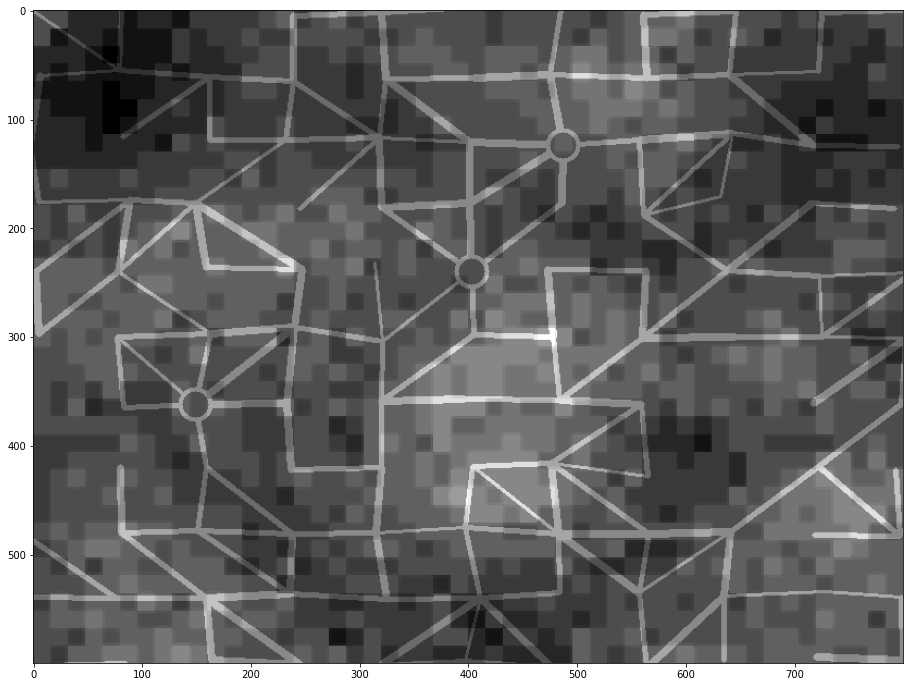

In [243]:
makeSatelliteMap((10, 10), 800, 600, name="satellite_map", seed=123, threshold=0.7, max_roundabouts=3)
city_graph = cv2.imread('satellite_map.png')
print(city_graph.shape)
# cv2_imshow(city_graph)
show_image(city_graph)

# Path finding

In [244]:
def get_mask():
    X = np.linspace(0, 1, 64)
    Y = np.linspace(0, 1, 64)
    r = 1.5
    v1 = sum([sum([1 for x in X if (x-r)**2+(y-r)**2 <= r*r]) for y in Y]) / 64**2
    v2 = sum([sum([1 for x in X if (x-r)**2+y**2 <= r*r]) for y in Y]) / 64**2


    mask = np.array([[v1, v2, v1], [v2, 1.0, v2], [v1, v2, v1]])

    for i in range(4):
        mask = mask * mask
        s = sum(sum(mask)) - mask[1, 1]
        mask[1, 1] = s
        mask = mask / s

    mask = -mask
    mask[1, 1] = -mask[1, 1]

    return mask

def get_binary_image(input_image, threshold=55):
    mask = get_mask()

    def prog(img, b=64):
        return (img >= b).astype(np.uint8) * 255

    gray = input_image[::2, ::2, 0]
    gray = cv2.GaussianBlur(gray,(5,5), 0)
    dst = gray.astype(float) / 255

    dst = cv2.filter2D(dst, -1, mask)
    _min = dst.min()
    _max = dst.max()
    dst = (dst-_min)/(_max-_min)

    dst = dst**2

    return prog(dst*255, threshold)

def get_reachable_image(input_image, start_point):
    image = np.where(input_image > 0, 1, 0)

    reachable_image = np.zeros(image.shape)
    reachable_image[start_point[1]][start_point[0]] = 1

    image_size_x = image.shape[1]
    image_size_y = image.shape[0]

    reachable_stack = [start_point]
    while len(reachable_stack) > 0:
        current_point = reachable_stack.pop()

        min_x = max(0, current_point[0] - 1)
        max_x = min(image_size_x - 1, current_point[0] + 1)
        min_y = max(0, current_point[1] - 1)
        max_y = min(image_size_y - 1, current_point[1] + 1)

        neighbors = [(x, y) for y in range(min_y, max_y + 1) for x in range(min_x, max_x + 1)]

        for point in neighbors:
            x = point[0]
            y = point[1]
            if image[y][x] == 1 and reachable_image[y][x] == 0:
                reachable_image[y][x] = 1
                reachable_stack.append(point)

    return reachable_image

def get_weighted_image(input_image):
    weighted_image = input_image
    eroded_image = input_image

    while True:
        eroded_image = cv2.erode(eroded_image, np.ones((3, 3)))

        if eroded_image.max() == 0:
            break

        weighted_image = weighted_image + eroded_image

    return weighted_image

def get_skeletonized_image(input_image, weighted_image):
    skeleton = morphology.skeletonize(input_image)
    skeletonized_image = weighted_image
    skeletonized_image[~skeleton] = 0
    return skeletonized_image

def get_reachable_points(skeletonized_image):
    reachable_points = set()
    for y in range(skeletonized_image.shape[0]):
        for x in range(skeletonized_image.shape[1]):
            if skeletonized_image[y, x] > 0:
                reachable_points.add((x, y))
    return reachable_points

def get_intersection_points(reachable_points, start_point, target):
    intersection_points = set()
    for point in reachable_points:
        neighbors = [(x, y) for x in range(point[0] - 1, point[0] + 2) for y in range(point[1] - 1, point[1] + 2)]
        neighbors = [i for i in neighbors if i in reachable_points and i != point]
        if len(neighbors) > 2:
            intersection_points.add(point)

    if start_point not in intersection_points:
        intersection_points.add(start_point)

    if target not in intersection_points:
        intersection_points.add(target)

    return intersection_points

def get_paths(reachable_points, intersection_points):
    available_points = reachable_points.copy()
    paths = []

    for intersection_point in intersection_points:
        neighbors = [(x, y) for x in range(intersection_point[0] - 1, intersection_point[0] + 2) for y in range(intersection_point[1] - 1, intersection_point[1] + 2)]
        neighbors = [i for i in neighbors if i in available_points and i != intersection_point]

        # Intersection next to another intersection
        for end in [i for i in neighbors if i in intersection_points]:
            # Avoid path duplication
            if [end, intersection_point] not in paths:
                paths.append([intersection_point, end])

        path_beginings = [i for i in neighbors if i not in intersection_points]
        for path_begining in path_beginings:
            path_point = path_begining
            path = [intersection_point, path_point]
            last_point = intersection_point

            while True:
                neighbors = [(x, y) for x in range(path_point[0] - 1, path_point[0] + 2) for y in range(path_point[1] - 1, path_point[1] + 2)]
                neighbors = [i for i in neighbors if i != path_point and i != last_point and i in available_points]

                if len(neighbors) == 0:
                    # No append to avoid some dead ends
                    break            

                # No more than 1 next point possible
                last_point = path_point
                path_point = neighbors[0]
                path.append(path_point)
                
                if path_point in intersection_points:
                    paths.append(path)
                    break

            # Avoid path duplication
            for i in range(1, len(path) - 1):
                available_points.remove(path[i])

    return paths

def get_graph(skeletonized_image, paths):
    vertices = set()
    edges = set()
    vertices_costs = {}
    edges_costs = {}
    path_by_edge = {}

    for path in paths:
        begin = path[0]
        if begin not in vertices:
            vertices.add(begin)
            vertices_costs[begin] = 1 / skeletonized_image[begin[1], begin[0]]

        end = path[-1]
        if end not in vertices:
            vertices.add(end)
            vertices_costs[end] = 1 / skeletonized_image[end[1], end[0]]

        edge = ((begin, end))
        edges.add(edge)

        cost = 0
        for i in range(1, len(path) - 1):
            cost += 1 / skeletonized_image[path[i][1], path[i][0]]

        edges_costs[edge] = cost

        path_by_edge[edge] = path

        edges_by_vertice = {}
        for edge in edges:
            end_points = [edge[0], edge[1]]
            for end_point in end_points:
                if end_point not in edges_by_vertice.keys():
                    edges_by_vertice[end_point] = []

                edges_by_vertice[end_point].append(edge)

    return {
        "vertices": vertices,
        "edges": edges,
        "vertices_costs": vertices_costs,
        "edges_costs": edges_costs,
        "path_by_edge": path_by_edge,
        "edges_by_vertice": edges_by_vertice
    }

class Ant:
    def __init__(self, start_point, target, graph, pheromone_by_edge, peheromone_strength, random_respawn_probability):
        self.vertices = graph["vertices"]
        self.edges = graph["edges"]
        self.vertices_costs = graph["vertices_costs"]
        self.edges_costs = graph["edges_costs"]
        self.edges_by_vertice = graph["edges_by_vertice"]
        
        self.start_point = start_point
        self.target = target
        
        self.random_respawn_probability = random_respawn_probability

        self.respawn()

        self.pheromone_by_edge = pheromone_by_edge
        self.pheromone_strength = peheromone_strength

        self.visited_edges = set()
        self.moves_cost = 0

    def move(self):
        moves = self.edges_by_vertice[self.position]
        moves = [i for i in moves if i not in self.visited_edges]
        if len(moves) == 0:
            # Going in a loop => die
            self.respawn()
            return
        
        move_probabilities = [1 + self.pheromone_by_edge[i] for i in moves]
        probabilities_sum = sum(move_probabilities)
        move_probabilities = [i / probabilities_sum for i in move_probabilities]
        move = random.choices(moves, move_probabilities)[0]

        self.position = move[0] if move[0] != self.position else move[1]
        self.visited_edges.add(move)
        self.moves_cost += self.edges_costs[move] + self.vertices_costs[self.position]

        if self.position == self.target:
            for edge in self.visited_edges:
                self.pheromone_by_edge[edge] += self.pheromone_strength / math.log(self.moves_cost)

            self.respawn()

    def respawn(self):
        self.position = random.choice([i for i in self.vertices]) if random.randrange(int(100 / self.random_respawn_probability)) < 100 else self.start_point
        self.visited_edges = set()
        self.moves_cost = 0

def simulate_ants(graph, start_point, target):
    pheromone_by_edge = {}
    for edge in graph["edges"]:
        pheromone_by_edge[edge] = 0

    for iteration in range(10):
        evaporation_rate = math.pow(math.e, -0.01 * iteration) 

        num_ants = 500
        pheromone_strength = 100
        ants = [Ant(start_point, target, graph, pheromone_by_edge, pheromone_strength, 2 / max(1, iteration)) for _ in range(num_ants)]

        for _ in range(200):
            for ant in ants:
                ant.move()

            for edge in pheromone_by_edge.keys():
                pheromone_by_edge[edge] *= evaporation_rate

    return pheromone_by_edge

def get_strongest_pheromone_path(graph, pheromone_by_edge, start_point, target):
    strongest_pheromone_path = [start_point]
    position = start_point
    visited_edges = set()
    while position != target:
        edges = [i for i in graph["edges_by_vertice"][position] if i not in visited_edges]
        if len(edges) == 0:
            return False, "Ants began to walk in a loop and died."
        
        strongest_pheromone_edge = edges[0]
        strongest_pheromone = pheromone_by_edge[strongest_pheromone_edge]
        for edge in edges:
            if pheromone_by_edge[edge] > strongest_pheromone:
                strongest_pheromone = pheromone_by_edge[edge]
                strongest_pheromone_edge = edge

        visited_edges.add(strongest_pheromone_edge)
        
        path = graph["path_by_edge"][strongest_pheromone_edge]
        edge_end = strongest_pheromone_edge[1] if strongest_pheromone_edge[0] == position else strongest_pheromone_edge[0]

        for i in path[1:-1]:
            strongest_pheromone_path.append(i)
        strongest_pheromone_path.append(edge_end)

        position = edge_end

    return True, strongest_pheromone_path

def find_path(input_image, start_point, target):
    binary_image = get_binary_image(input_image, 55)
    reachable_image = get_reachable_image(binary_image, start_point)
    weighted_image = get_weighted_image(reachable_image)
    skeletonized_image = get_skeletonized_image(reachable_image, weighted_image)

    reachable_points = get_reachable_points(skeletonized_image)
    
    if start_point not in reachable_points:
        return False, f'Start point {start_point} is not on any road.'
    
    if target not in reachable_points:
        return False, f'Target {target} is not rachable from start point {start_point}.'
    
    intersection_points = get_intersection_points(reachable_points, start_point, target)
    paths = get_paths(reachable_points, intersection_points)

    graph = get_graph(skeletonized_image, paths)
    pheromone_by_edge = simulate_ants(graph, start_point, target)

    return get_strongest_pheromone_path(graph, pheromone_by_edge, start_point, target)

# Demo

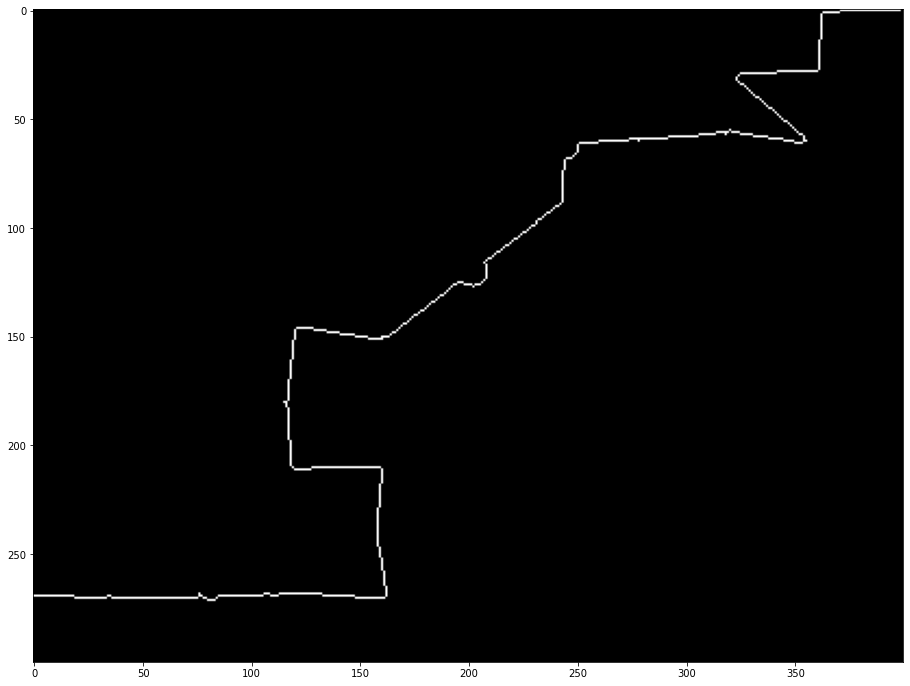

In [245]:
input_image = city_graph
start_point = (0, 269)
target = (398, 0)

path_found, result = find_path(input_image, start_point, target)

if path_found:
    image = np.zeros((300, 400))
    for point in result:
        image[point[1], point[0]] = 1

    show_image(image)
else:
    print(result)